# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-15'
end_date = '2021-11-21'

# Define extent
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-15T00:00:00Z', '2021-11-15T23:00:00Z'), ('2021-11-16T00:00:00Z', '2021-11-16T23:00:00Z'), ('2021-11-17T00:00:00Z', '2021-11-17T23:00:00Z'), ('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z'), ('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z'), ('2021-11-20T00:00:00Z', '2021-11-20T23:00:00Z'), ('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple',
                                               CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 7)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-15 2021-11-16 ... 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-06T12:13 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The columns above each CAMS half level will be calculated.
The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [11]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 3, step: 8, time: 7)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-15 2021-11-16 ... 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-06T12:15 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [12]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels,
                                        CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-15T00:00:00Z', '2021-11-15T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:15:40,881 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211115T132216_20211115T132716_21198_02_020200_20211115T140523
Number 1-S5P_NRTI_L2__NO2____20211115T114216_20211115T114716_21197_02_020200_20211115T122916
SELECTED
File name: d6a7e748-c65e-4e8e-84fb-bb44f2b99b7c
Product name: S5P_NRTI_L2__NO2____20211115T132216_20211115T132716_21198_02_020200_20211115T140523.nc
The file exists, it will not be downloaded again.
For ('2021-11-16T00:00:00Z', '2021-11-16T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:17,165 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211116T130216_20211116T130716_21212_02_020200_20211116T134652
SELECTED
File name: 85ab7ebc-82b4-4bd7-8442-9238d918053f
Product name: S5P_NRTI_L2__NO2____20211116T130216_20211116T130716_21212_02_020200_20211116T134652.nc
The file exists, it will not be downloaded again.
For ('2021-11-17T00:00:00Z', '2021-11-17T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:19,023 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211117T124442_20211117T124942_21226_02_020301_20211117T132701
SELECTED
File name: 82f44398-97fb-445f-9d09-da110f949040
Product name: S5P_NRTI_L2__NO2____20211117T124442_20211117T124942_21226_02_020301_20211117T132701.nc
The file exists, it will not be downloaded again.
For ('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:19,901 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211118T122442_20211118T122942_21240_02_020301_20211118T132903
SELECTED
File name: b7c959e3-6d3f-4bf6-9391-b1a9044d9dce
Product name: S5P_NRTI_L2__NO2____20211118T122442_20211118T122942_21240_02_020301_20211118T132903.nc
The file exists, it will not be downloaded again.
For ('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:20,698 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631
Number 1-S5P_NRTI_L2__NO2____20211119T120750_20211119T121250_21254_02_020301_20211119T131758
SELECTED
File name: a7487f85-de89-47fc-a855-85574fbd1702
Product name: S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631.nc
The file exists, it will not be downloaded again.
For ('2021-11-20T00:00:00Z', '2021-11-20T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:21,416 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211120T132750_20211120T133250_21269_02_020301_20211120T142235
Number 1-S5P_NRTI_L2__NO2____20211120T114750_20211120T115250_21268_02_020301_20211120T125332
SELECTED
File name: 2aba5f21-d070-4049-8a62-0637ba04ac3a
Product name: S5P_NRTI_L2__NO2____20211120T132750_20211120T133250_21269_02_020301_20211120T142235.nc
The file exists, it will not be downloaded again.
For ('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-06 12:16:22,141 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211121T131250_20211121T131750_21283_02_020301_20211121T141258
SELECTED
File name: 686a7bbd-4589-43e8-9ccb-8a416e226d43
Product name: S5P_NRTI_L2__NO2____20211121T131250_20211121T131750_21283_02_020301_20211121T141258.nc
The file exists, it will not be downloaded again.


In [14]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 7, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [15]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 7, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [16]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,  
                                   sensor, component_nom, apply_kernels)
match_table

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.
FOR DATE: 2021-11-15
FOR DATE: 2021-11-16
FOR DATE: 2021-11-17
FOR DATE: 2021-11-18
FOR DATE: 2021-11-19
FOR DATE: 2021-11-20
FOR DATE: 2021-11-21


pressure  index  \
time       ground_pixel scanline layer                         
2021-11-15 375.0        273.0    0.0    100370.765625      0   
                                 1.0     99046.992188      2   
                                 2.0     96701.265625      4   
                                 3.0     93202.015625      6   
                                 4.0     88178.367188      8   
...                                               ...    ...   
2021-11-21 347.0        68.0     29.0      625.780151  94102   
                                 30.0      309.465515  94104   
                                 31.0      130.429565  94106   
                                 32.0       44.064754  94108   
                                 33.0        9.304465  94110   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-15 375.0        273.0    0.0   2021-11-15 13:25:59.817  40.976803   
                                 1.0   2021-11-15 13:25:59.817  40.976803   
                                 2.0   2021-11-15 13:25:59.817  40.976803   
                                 3.0   2021-11-15 13:25:59.817  40.976803   
                                 4.0   2021-11-15 13:25:59.817  40.976803   
...                                                        ...        ...   
2021-11-21 347.0        68.0     29.0  2021-11-21 13:13:41.663  42.073036   
                                 30.0  2021-11-21 13:13:41.663  42.073036   
                                 31.0  2021-11-21 13:13:41.663  42.073036   
                                 32.0  2021-11-21 13:13:41.663  42.073036   
                                 33.0  2021-11-21 13:13:41.663  42.073036   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-15 375.0        273.0    0.0     1.541311       1.0   2.425610e+15   
                                 1.0     1.541311       1.0   2.425610e+15   
                                 2.0     1.541311       1.0   2.425610e+15   
                                 3.0     1.541311       1.0   2.425610e+15   
                                 4.0     1.541311       1.0   2.425610e+15   
...                                           ...       ...            ...   
2021-11-21 347.0        68.0     29.0    2.474224       1.0   1.212600e+15   
                                 30.0    2.474224       1.0   1.212600e+15   
                                 31.0    2.474224       1.0   1.212600e+15   
                                 32.0    2.474224       1.0   1.212600e+15   
                                 33.0    2.474224       1.0   1.212600e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-15 375.0        273.0    0.0                                         0.000013   
                                 1.0                                         0.000013   
                                 2.0                                         0.000013   
                                 3.0                                         0.000013   
                                 4.0                                         0.000013   
...                                                                               ...   
2021-11-21 347.0        68.0     29.0                                        0.000019   
                                 30.0                                        0.000019   
                                 31.0                                        0.000019   
                                 32.0                                        0.000019   
                                 33.0                                        0.000019   

                                     

## 5. Merge data and calculate difference

In [17]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
375.0        273.0    2021-11-15  40.976803   1.541311           NaN   
             274.0    2021-11-15  41.025761   1.530660  1.860702e+15   
             275.0    2021-11-15  41.074738   1.520018  2.112371e+15   
             276.0    2021-11-15  41.123718   1.509346  2.130975e+15   
             277.0    2021-11-15  41.172672   1.498640  2.348929e+15   
...                                     ...        ...           ...   
347.0        64.0     2021-11-21  41.877071   2.523361  1.597451e+15   
             65.0     2021-11-21  41.926060   2.511031  1.394554e+15   
             66.0     2021-11-21  41.975071   2.498754  1.621421e+15   
             67.0     2021-11-21  42.024044   2.486477  1.257098e+15   
             68.0     2021-11-21  42.073036   2.474224  1.286099e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
375.0        273.0    2021-11-15   2.425610e+15           NaN  
             274.0    2021-11-15   1.786660e+15 -7.404281e+13  
             275.0    2021-11-15   2.376777e+15  2.644063e+14  
             276.0    2021-11-15   2.558412e+15  4.274369e+14  
             277.0    2021-11-15   2.234778e+15 -1.141516e+14  
...                                         ...           ...  
347.0        64.0     2021-11-21   2.963371e+15  1.365920e+15  
             65.0     2021-11-21   3.105591e+15  1.711037e+15  
             66.0     2021-11-21   2.750030e+15  1.128609e+15  
             67.0     2021-11-21   2.309187e+15  1.052089e+15  
             68.0     2021-11-21   1.212600e+15 -7.349850e+13  

[2963 rows x 5 columns]

In [18]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,2963.000000,2963.000000,2.744000e+03,2.750000e+03,2.744000e+03
mean,41.494852,1.997747,2.573356e+15,3.705109e+15,1.133244e+15
std,0.314871,0.368495,2.003392e+15,2.489041e+15,2.712131e+15
min,40.749069,1.182532,4.853541e+14,-2.008896e+15,-1.111244e+16
25%,41.227690,1.689791,1.413066e+15,2.114204e+15,-1.592418e+13
50%,41.494400,1.995121,1.889316e+15,3.217077e+15,1.009919e+15
75%,41.759388,2.303931,2.792775e+15,4.741421e+15,2.273710e+15
max,42.178768,2.843978,1.398804e+16,1.979032e+16,1.662281e+16


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-15T00:00:00.000000000' '2021-11-16T00:00:00.000000000'
 '2021-11-17T00:00:00.000000000' '2021-11-18T00:00:00.000000000'
 '2021-11-19T00:00:00.000000000' '2021-11-20T00:00:00.000000000'
 '2021-11-21T00:00:00.000000000']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare CAMS and TROPOMI total columns

In [21]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

2021-12-06 13:04:47,597 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


2021-12-06 13:04:54,089 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-12-06 13:04:54,092 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x720 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y animation.mp4


### Compare CAMS original and averaged total columns

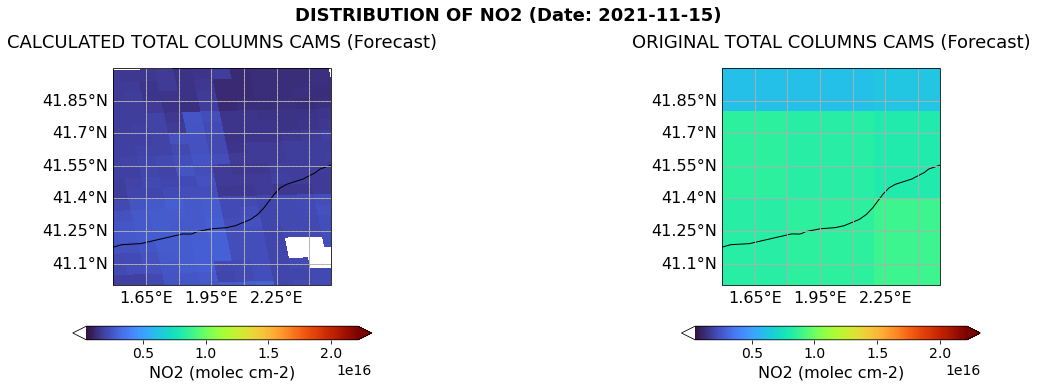

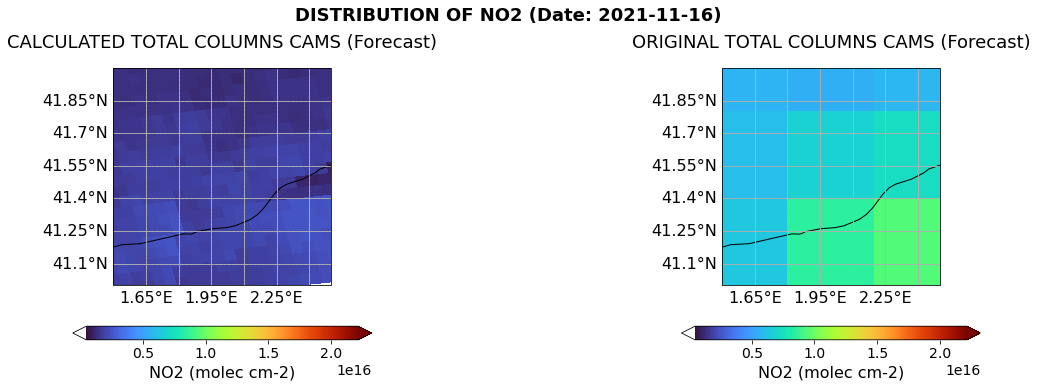

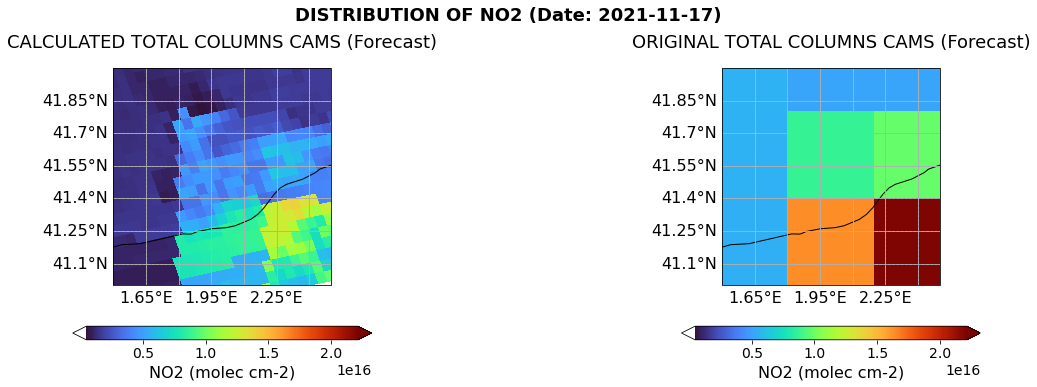

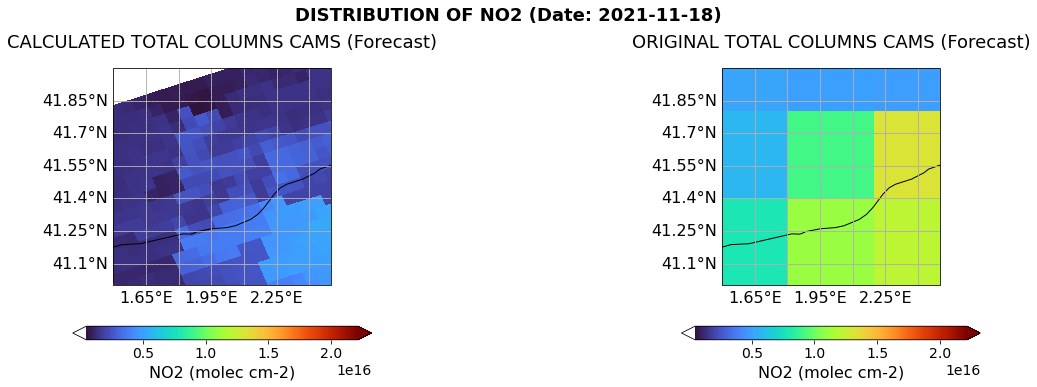

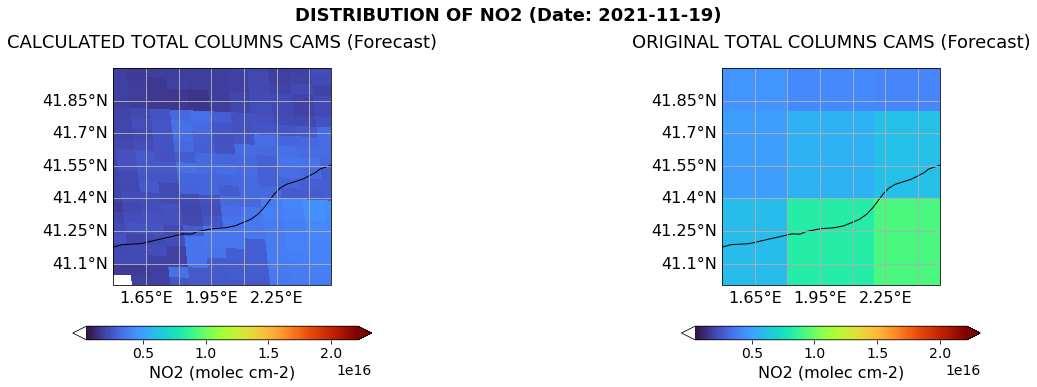

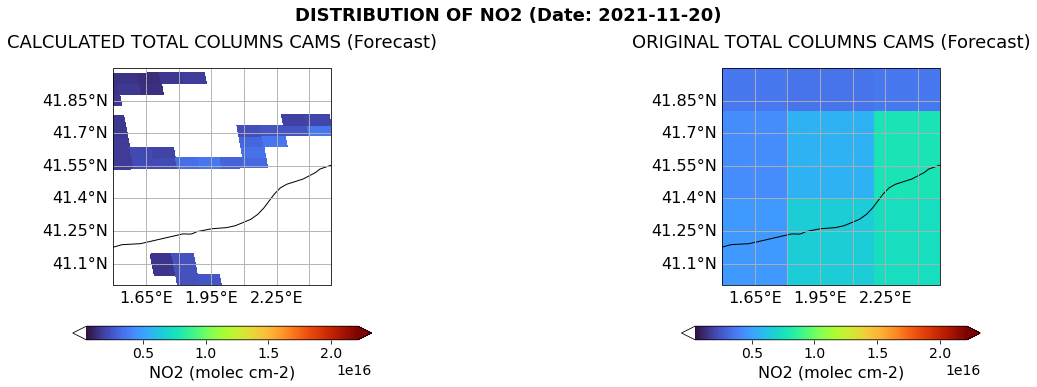

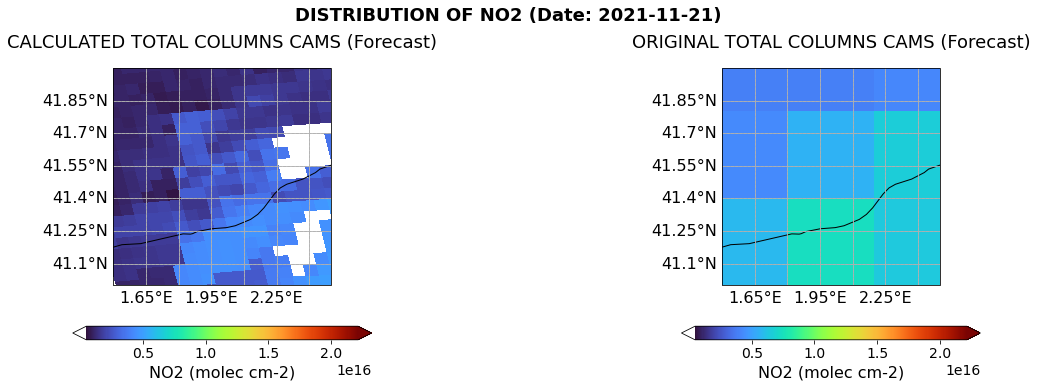

In [22]:
# Choose distribution (individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1.05, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

ground_pixel  scanline  \
lat_search lon_search latitude  longitude time                                 
41.39      2.15       41.390068 2.118585  2021-11-15         383.0     281.0   
                      41.409931 2.171800  2021-11-16         312.0     357.0   
                      41.393410 2.151046  2021-11-17         210.0     267.0   
                      41.399742 2.131338  2021-11-18         116.0     361.0   
                      41.385719 2.133770  2021-11-19         438.0     270.0   
                      41.564960 2.151526  2021-11-20         400.0     341.0   
                      41.399441 2.142174  2021-11-21         339.0      55.0   
41.10      1.65       41.129585 1.669390  2021-11-15         377.0     276.0   
                      41.095612 1.641320  2021-11-16         300.0     352.0   
                      41.128124 1.658061  2021-11-17         197.0     264.0   
                      41.075062 1.639512  2021-11-18         106.0     358.0   
                      41.118984 1.617174  2021-11-19         432.0     264.0   
                      41.120770 1.722398  2021-11-20         395.0     332.0   
                      41.105343 1.627771  2021-11-21         329.0      50.0   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
41.39      2.15       41.390068 2.118585  2021-11-15  2.160767e+15   
                      41.409931 2.171800  2021-11-16  1.922813e+15   
                      41.393410 2.151046  2021-11-17  7.101340e+15   
                      41.399742 2.131338  2021-11-18  2.683950e+15   
                      41.385719 2.133770  2021-11-19  3.167504e+15   
                      41.564960 2.151526  2021-11-20  3.140931e+15   
                      41.399441 2.142174  2021-11-21  3.455631e+15   
41.10      1.65       41.129585 1.669390  2021-11-15  2.371324e+15   
                      41.095612 1.641320  2021-11-16  1.932274e+15   
                      41.128124 1.658061  2021-11-17  1.108624e+15   
                      41.075062 1.639512  2021-11-18  1.105803e+15   
                      41.118984 1.617174  2021-11-19  2.198149e+15   
                      41.120770 1.722398  2021-11-20  1.541992e+15   
                      41.105343 1.627771  2021-11-21  1.502496e+15   

                                                      sensor_column  \
lat_search lon_search latitude  longitude time                        
41.39      2.15       41.390068 2.118585  2021-11-15   1.252238e+13   
                      41.409931 2.171800  2021-11-16   4.619110e+15   
                      41.393410 2.151046  2021-11-17   7.776110e+15   
                      41.399742 2.131338  2021-11-18   1.771568e+16   
                      41.385719 2.133770  2021-11-19   1.979032e+16   
                      41.564960 2.151526  2021-11-20   6.613655e+15   
                      41.399441 2.142174  2021-11-21   1.136175e+16   
41.10      1.65       41.129585 1.669390  2021-11-15   2.983563e+15   
                      41.095612 1.641320  2021-11-16   2.525397e+15   
                      41.128124 1.658061  2021-11-17   3.089458e+15   
                      41.075062 1.639512  2021-11-18   3.668668e+15   
                      41.118984 1.617174  2021-11-19   5.382786e+15   
                      41.120770 1.722398  2021-11-20   2.470069e+15   
                      41.105343 1.627771  2021-11-21   2.296009e+15   

                                                        difference  
lat_search lon_search latitude  longitude time                      
41.39      2.15       41.390068 2.118585  2021-11-15 -2.148244e+15  
                      41.409931 2.171800  2021-11-16  2.696297e+15  
                      41.393410 2.151046  2021-11-17  6.747702e+14  
                      41.399742 2.131338  2021-11-18  1.503173e+16  
                      41.385719 2.133770  2021-11-19  1.662281e+16  
                      41.564960 

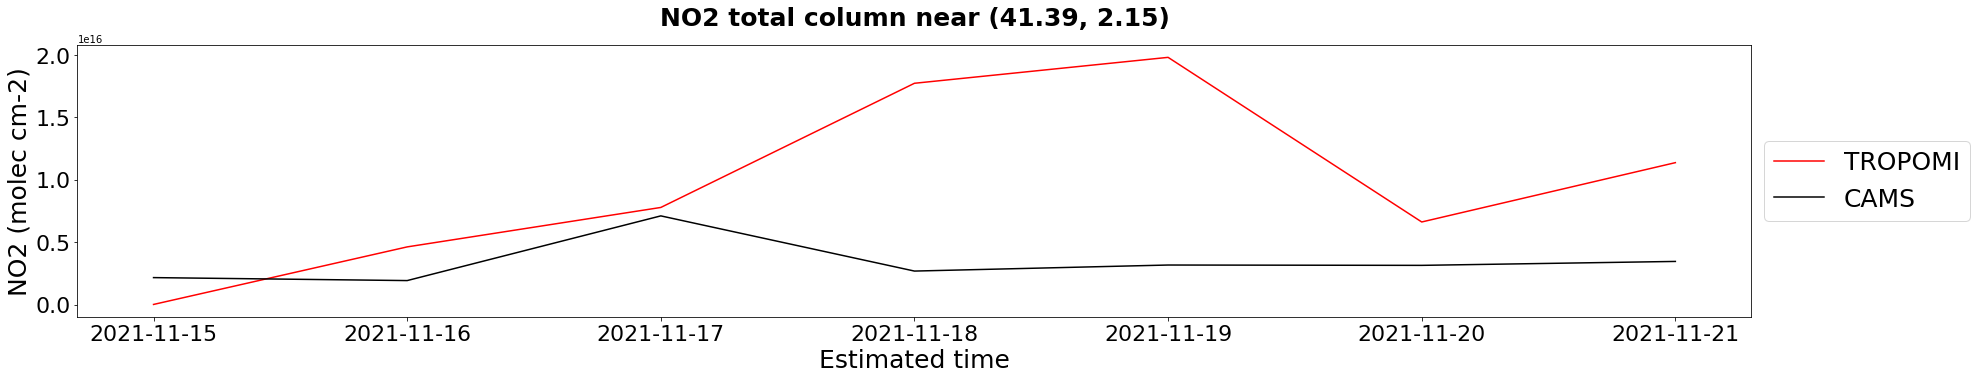

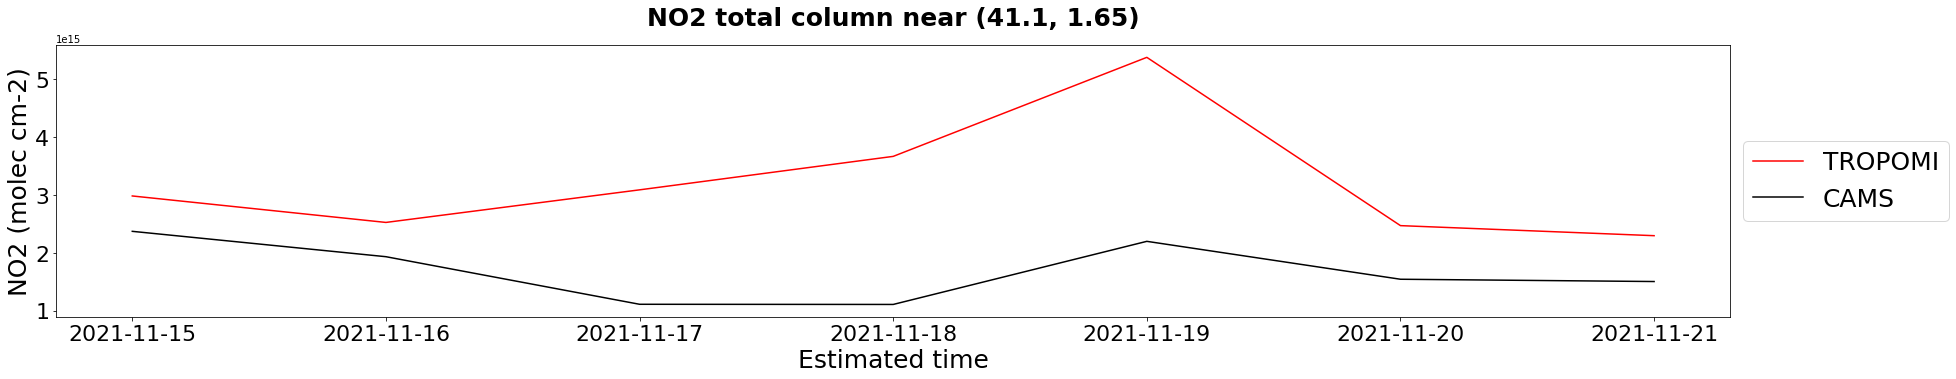

In [23]:
coords_search_list = (41.39, 2.15,
                      41.1, 1.65)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.16 + (1.82E+15)
Coefficient of determination (R2): 0.16


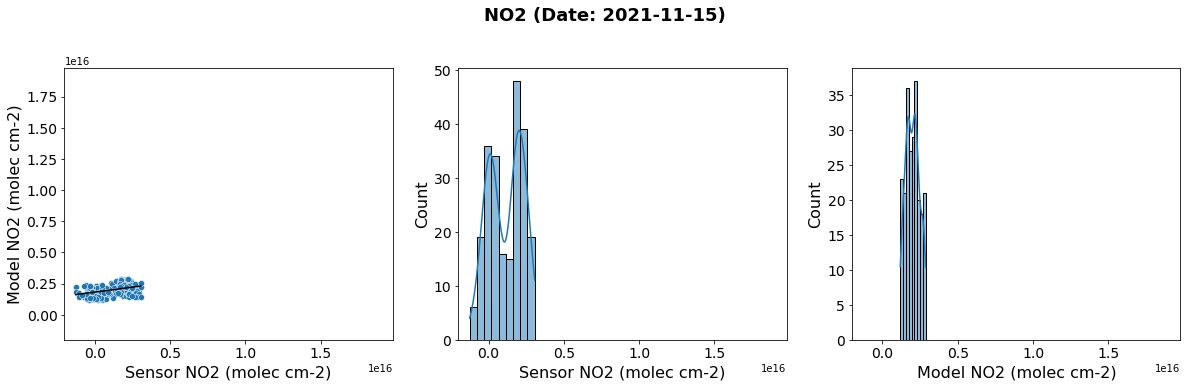

Fit equation: NO2_model = NO2_sensor * 0.13 + (1.37E+15)
Coefficient of determination (R2): 0.26


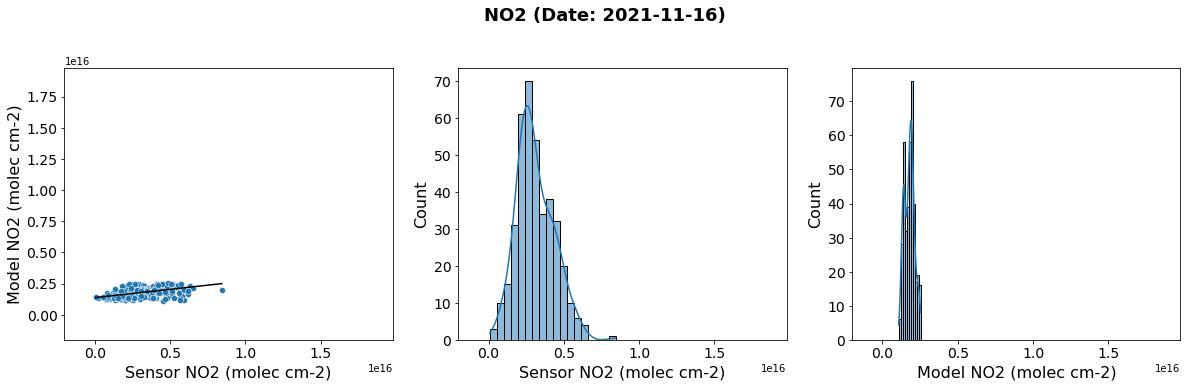

Fit equation: NO2_model = NO2_sensor * 0.96 + (4.47E+14)
Coefficient of determination (R2): 0.30


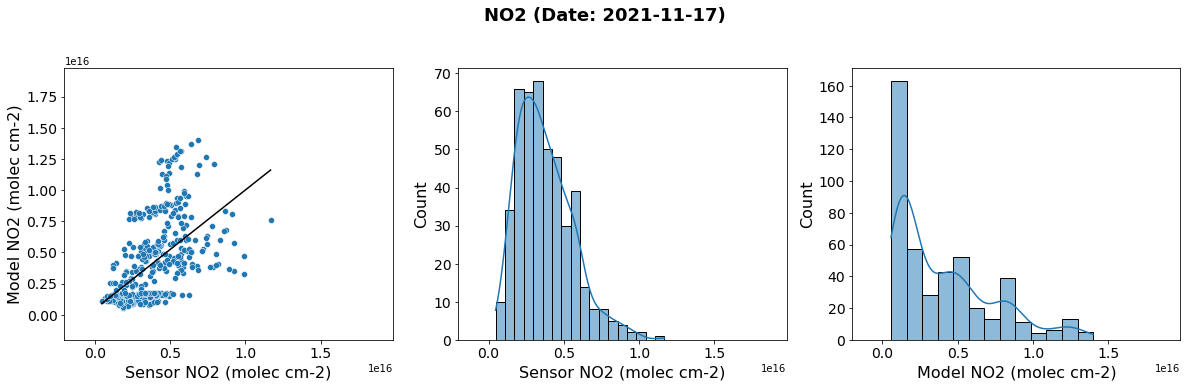

Fit equation: NO2_model = NO2_sensor * 0.17 + (1.36E+15)
Coefficient of determination (R2): 0.11


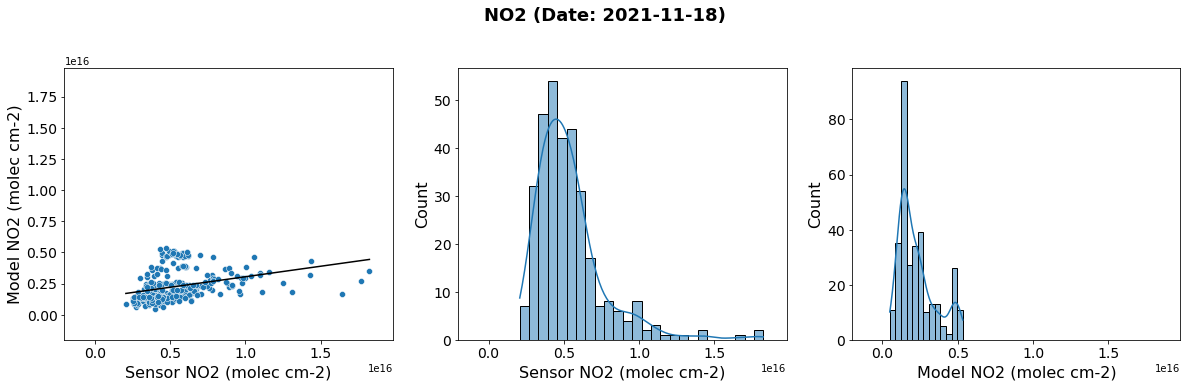

Fit equation: NO2_model = NO2_sensor * 0.11 + (1.80E+15)
Coefficient of determination (R2): 0.29


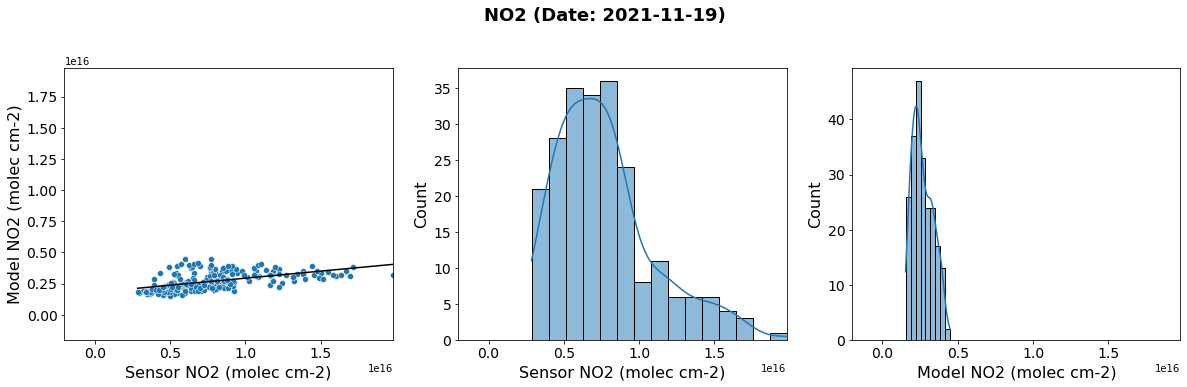

Fit equation: NO2_model = NO2_sensor * 0.23 + (1.43E+15)
Coefficient of determination (R2): 0.44


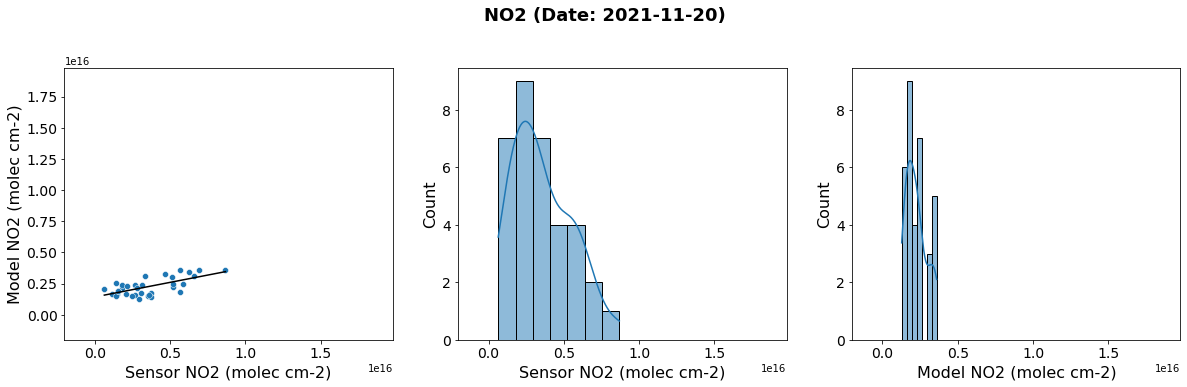

Fit equation: NO2_model = NO2_sensor * 0.22 + (1.46E+15)
Coefficient of determination (R2): 0.23


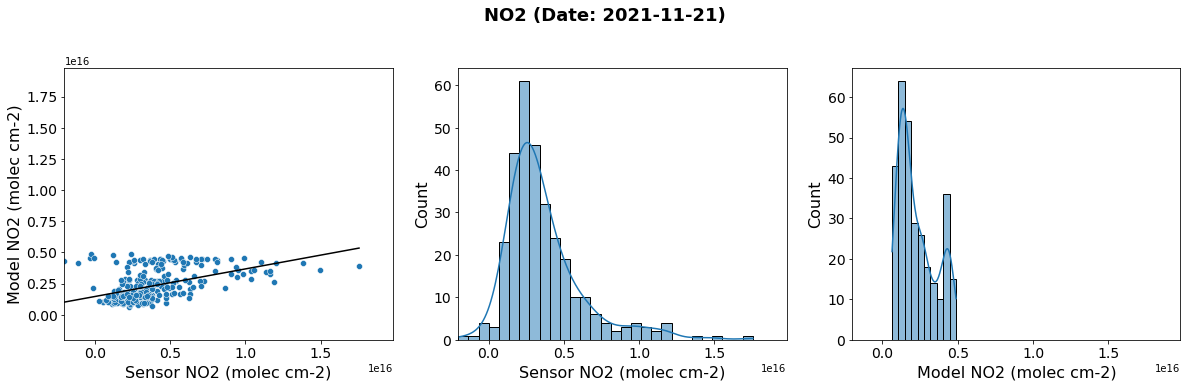

In [24]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [25]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-15,"((1.5, 41), (2.5, 42))",0.162856,0.160519,1.815301e+15
1,2021-11-16,"((1.5, 41), (2.5, 42))",0.258150,0.133276,1.372524e+15
2,2021-11-17,"((1.5, 41), (2.5, 42))",0.295645,0.955298,4.472586e+14
3,2021-11-18,"((1.5, 41), (2.5, 42))",0.105589,0.168611,1.360772e+15
4,2021-11-19,"((1.5, 41), (2.5, 42))",0.287911,0.112911,1.804372e+15
5,2021-11-20,"((1.5, 41), (2.5, 42))",0.435923,0.233841,1.426596e+15
6,2021-11-21,"((1.5, 41), (2.5, 42))",0.233201,0.221353,1.461000e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.21 + (1.75E+15)
Coefficient of determination (R2): 0.09


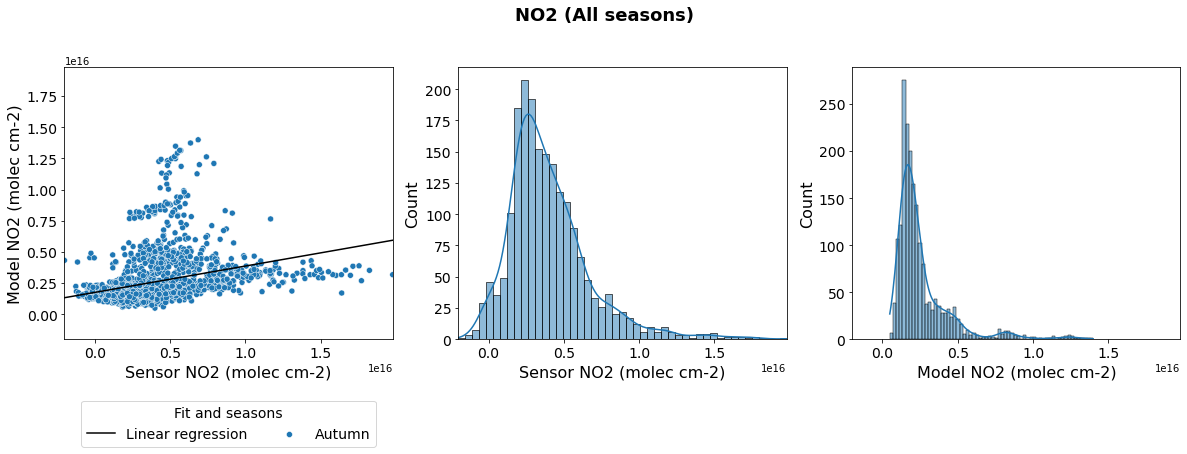

In [26]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [27]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[Autumn],"((1.5, 41), (2.5, 42))",0.092087,0.211415,1.746434e+15


## 10. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [29]:
#summary